## Julia / Yao implementation of a VQE for finding the ground state of H2.

For this implementation we use a part of QuAlgorithmZoo.jl's VQE_openfermion found [here](https://github.com/QuantumBFS/QuAlgorithmZoo.jl/blob/master/examples/VQE_openfermion/main.jl). The original implementation uses a VQE to find the lowest energy state at specific predefined bond lengths. 

The main change compared to the original is the usage of the golden-section search to find the ground state energy of the system. The golden section search tries to find the lowest energy state and by updating the bond length, it finds the ground state.

Here we added a iteration function `VQE()` to average the results. 

In these examples we use Julia `Version 1.10.3 (2024-04-30)`.

---

#### Hamiltonian creation

We use [OpenFermion](https://github.com/quantumlib/OpenFermion), a python library, for the creation of the hamiltonian.

With OpenFermion, we create a [sto3g](https://en.wikipedia.org/wiki/STO-nG_basis_sets) basis set H2 molecule at a specific bond length. 

After, we create the hamiltonians under [Jordan-Weigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation) and transform it to a Yao circuit.

---

#### VQE

We use the [VQE](https://github.com/QuantumBFS/QuAlgorithmZoo.jl/blob/master/examples/VQE/main.jl) example found in QuAlgorithmZoo.jl:

We use an `ADAM` optimizer from [Flux Optimizers.jl](https://fluxml.ai/Optimisers.jl/stable/) to find the ground state, in combination with Yao's [`variational_circuit`](https://yaoquantum.org/YaoExtensions.jl/dev/#YaoExtensions.variational_circuit-Tuple{Any,Any,Any}) as Ansatz. 

It uses julia's [Flux.jl](https://fluxml.ai/Flux.jl/stable/) `train!` function to perform the VQE iterations to find the lowest energy state. 

In [ ]:
# Original code can be found at: https://github.com/QuantumBFS/QuAlgorithmZoo.jl/blob/master/examples/VQE_openfermion/main.jl 

using Yao
using Yao.EasyBuild

# Here we we invoke [OpenFermion](https://github.com/quantumlib/OpenFermion) in Python
# to get the hamiltonian under [Jordan-Weigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation)
# (with 2 electrons and 4 sto-3g basis set orbitals).

using PyCall

py"""
import numpy as np
from openfermion.config import *
from openfermion import MolecularData
from openfermion.transforms import jordan_wigner
from openfermionpyscf import run_pyscf

def make_H2_mol(bond_len):
    ## Returns:
    ##     molecule(openfermion.hamiltonians.MolecularData):
    ## MolecularData for H2 with certain bond length
    
    ## Create molecule
    atom_1 = 'H'
    atom_2 = 'H'
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    coordinate_1 = (0.0, 0.0, 0.0)
    coordinate_2 = (0.0, 0.0, bond_len)
    geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]
    molecule = MolecularData(geometry, basis, multiplicity,
    charge, description=str(bond_len))
    molecule = run_pyscf(molecule,run_scf=1,run_ccsd=1,run_fci=1)
    return molecule

def get_hamiltonian(bond_len):
    ## get the coefficients and pauli terms of Hamiltonian of H_2 with given bond length
    ## Returns:
    ##     (PyArray,PyArray)
    molecule = make_H2_mol(bond_len)
    qubit_hamiltonian = jordan_wigner(molecule.get_molecular_hamiltonian())
    qubit_hamiltonian.compress()
    return list(qubit_hamiltonian.terms.keys()),list(qubit_hamiltonian.terms.values())

"""

# Define the function to transfer OpenFermion hamiltonian to Yao circuit

function get_fermion_hamiltonian(n::Int,terms::Array,coefs::Vector)
    gates=Dict("Z"=>Z,"X"=>X,"Y"=>Y)
    to_pauli(t::Tuple{Int,String})=put(n,t[1]+1=>get(gates,t[2],ErrorException("Invalid")))
    return sum(coefs[2:end].*map(x->reduce(*,map(to_pauli,x)),terms[2:end]))
end

using Flux: Optimise

function train!(circ, hamiltonian; optimizer, niter::Int=2500,verbose::Bool=true)
     params = parameters(circ)
     dispatch!(circ, :random)
     for i=1:niter
         _, grad = expect'(hamiltonian, zero_state(nqubits(circ)) => circ)
         Optimise.update!(optimizer, params, grad)
         dispatch!(circ, params)
         if verbose
            println("Energy = 
            $(expect(hamiltonian, zero_state(nqubits(hamiltonian)) |> circ) |> real)")
         end
     end
     return expect(hamiltonian, zero_state(nqubits(hamiltonian)) |> circ)
end

# Train VQE to search ground energy on various bond lengths.

using LinearAlgebra

function vqe_calculation(bond_len)
    terms, coefs = py"get_hamiltonian"(bond_len)

    e = coefs[1]
    
    h = get_fermion_hamiltonian(4,terms,coefs)
    c = variational_circuit(4)
    
    emin_vqe = train!(c, h; optimizer=Optimise.ADAM(0.002, (0.9, 0.99)),verbose=false)
    
    emin = eigvals(Matrix(mat(h)))[1]
    @assert isapprox(emin, emin_vqe, atol=1e-3)

    return e+emin_vqe|>real
end 

## Plotting results

Here we use the collection(0.5:0.05:2.8) to create points between 0.5 and 2.8 with steps of 0.05 to create the energy curve of the H2 molecule.

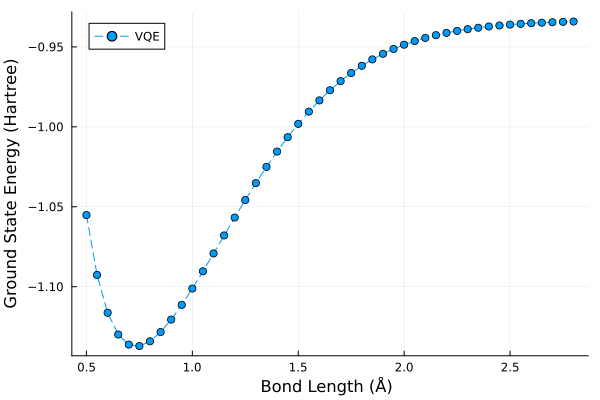

In [42]:
bond_lens = collect(0.5:0.05:2.8)#\AA
pes = Vector{Float64}()

for l in bond_lens
    results = vqe_calculation(l)

    push!(pes,results) 
end

using Plots

Plots.plot(bond_lens,pes, markershape = :circle, linestyle = :dash, label = "VQE",ylabel = "Ground State Energy (Hartree)", xlabel = "Bond Length (Å) ")

## Finding the ground state energy

We use the `GoldenSection()` search found in [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/user/minimization/). To find the minimum ground state energy. It tries to find the minimum of the input (in this case the VQE function) along the energy curve between 0.5 and 1. 

For evaluation we used Julia's built in [@time](https://docs.julialang.org/en/v1/manual/performance-tips/#Measure-performance-with-[@time](@ref)-and-pay-attention-to-memory-allocation) function to time the execution of the program and see the used system resources. 

In [ ]:
# Using a search function GoldenSection() to find the lowest energy state of the system. 
# More can be found at: https://julianlsolvers.github.io/Optim.jl/stable/user/minimization/ 

using Optim

function vqe(iter=1)
    minimizer_result::Float64 = 0
    minimum_result::Float64 = 0

    for i in 1:iter
        print("Iteration: $(i) process result: ")
        @time results = optimize(vqe_calculation, 0.5, 1, GoldenSection();)

        minimizer_result += results.minimizer
        minimum_result += results.minimum
    end
    print("End results: \n")

    print("Minimum bond length: $(minimizer_result/iter)\n")
    print("Minimum energy: $(minimum_result/iter)\n")

end

# Run the VQE: input the number of iterations you want to perform.
@time vqe(2)